# **Plotting Skin Friction *'C<sub>f</sub>'* with Respect to '*divSchemes*'**

This notebook is for comparison of various divergence schemes for skin friction. The procedures are almost the same with '*PlotCf.ipynb*', and thus the detail explanation can be referred to in that notebook.

In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# increase dpi and use latex rendering
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

# Set macro for paths
run = "../run/"
ds = "./output/divSchemes/"
!mkdir -p output
!mkdir -p output/divSchemes

## **1. Set Related Variables in Accordance with the Case Data**

Unlike '*PlotCf.ipynb*', only *1e-5* of **SIMPLE** residual limit is used. Instead, each divergence scheme for velocity is investigated in this notebook.

Here, total 4 divergence schemes for velocity are investigated which are given below.
1. '*linear*'\
This scheme uses an owner cell center value and a neighbor cell center value in order to estimate the face value between them. Therefore, it is a second order method, but unbounded (it sometimes shows unphysical behavior).
2. '*linearUpwind grad(U)*'\
The scheme is also a second order method as well as unbounded, but it is upwind-biased which means the direction is somewhat restricted to the upwind direction. Here, the velocity gradient is used for the scheme.
3. '*limitedLinear 1*'\
This scheme behaves as an upwind scheme where the gradient strongly changes. If the coefficient is 1, it is severely limited to an upwind scheme, while it corrresponds to a linear scheme if the coefficient is 0.
4. '*upwind*'\
It is a first order method, and thus the solution can be bounded easier than the second order methods. Only the previous cell center value is considered to calculate the face value. However, the direction of the propagation is limited, and thus if the presumed direction is wrong, the solution totally crashes. Even if the direction of the propagation is correct, any smearing phenomena should be taken into consideration.

For more detail explanation, the following link can be referred to:\
https://cfd.direct/openfoam/user-guide/v6-fvschemes/

In [2]:
UInf = 69.4
nuInf = 1.388e-05
model = "kOmegaSST"
yp = ['0.05', '1', '2', '5', '10', '30', '50', '100']
fixed_res = '1e-5'
divSchemes = ['limitedLinear', 'linear', 'linearUpwind', 'upwind']

## **2. Load Data**

In [3]:
tauw_path_ds = [run + 'turbulentFlatPlate_noWallFunc_divSchemes/UdivSchemes/yplus_{}/{}/tauw_{}_{}_{}_{}.csv'.format(yp[j], divSchemes[i], model, yp[j], fixed_res, divSchemes[i]) for j in range(len(yp)) for i in range(len(divSchemes))]
tauw_data_ds = [pd.read_csv(tauw_path_ds[i + len(divSchemes)*j], delim_whitespace=True) for j in range(len(yp)) for i in range(len(divSchemes))]
tauw_data_ds[0].head()

,ccx,tau_xx,tau_yy,tau_zz
0,0.000486,-49.1798,-0.876573,0
1,0.001458,-20.4226,-0.005202,0
2,0.002433,-14.7404,-0.001212,0
3,0.003410,-12.1909,-0.000591,0
4,0.004390,-10.7133,-0.000372,0


## **3. Calculation of *'Re<sub>x</sub>'* and *'C<sub>f</sub>'***

In [4]:
x0 = 0
Rex = (tauw_data_ds[0]['ccx'] - x0)*UInf/nuInf
Cf = [np.sqrt(tauw_data_ds[i + len(divSchemes)*j]['tau_xx']**2 + tauw_data_ds[i + len(divSchemes)*j]['tau_yy']**2 + tauw_data_ds[i + len(divSchemes)*j]['tau_zz']**2)/(0.5*UInf**2) for j in range(len(yp)) for i in range(len(divSchemes))]

## **4. Weighardt's Equation**

In [5]:
weighardt = 0.288*(np.log10(Rex))**(-2.45)

## **5. Plot**

As seen below, we can observe that there is no noticeable difference amongst the schemes for y+ >= 10, whereas only '*linear*' scheme shows no oscillation at the front of the plate unlike the others for y+ <= 5. This '*linear*' scheme is unbounded, but it is the fully second order method without any restrictions of direction. Moreover, we investigate the wall faces which do not correspond to internal faces. Hence, it implies that a higher order method without restrictions is able to capture the behavior of the analytical solution appropriately at the wall in case without wall functions.

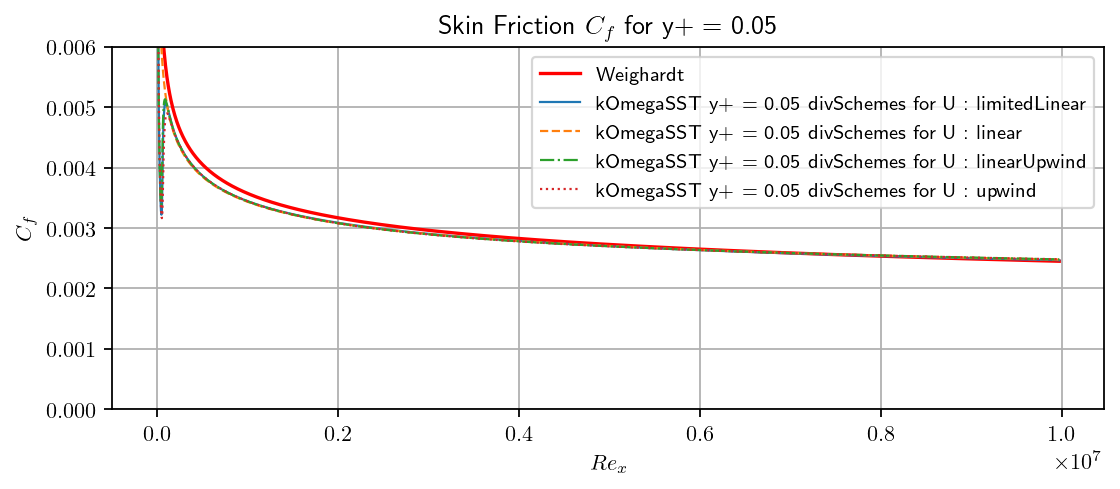

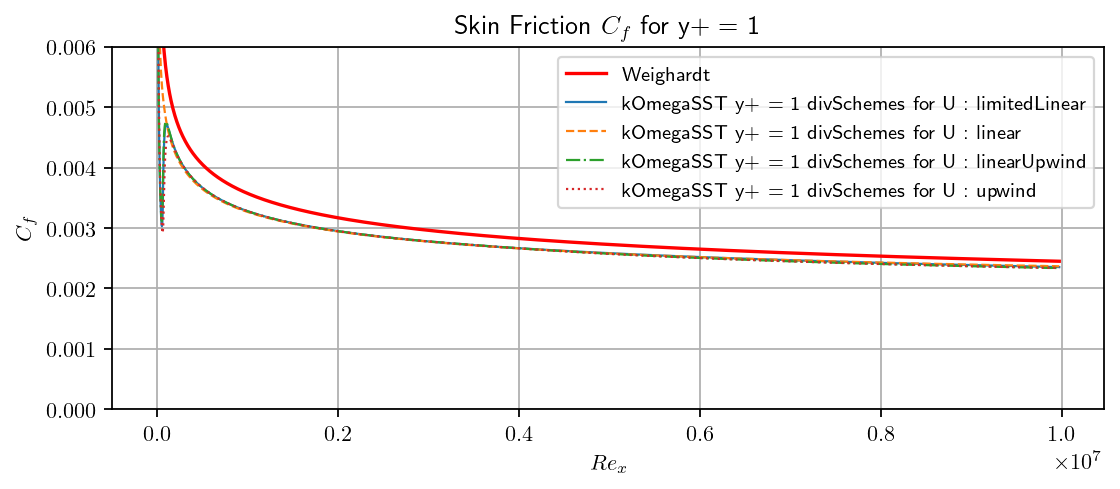

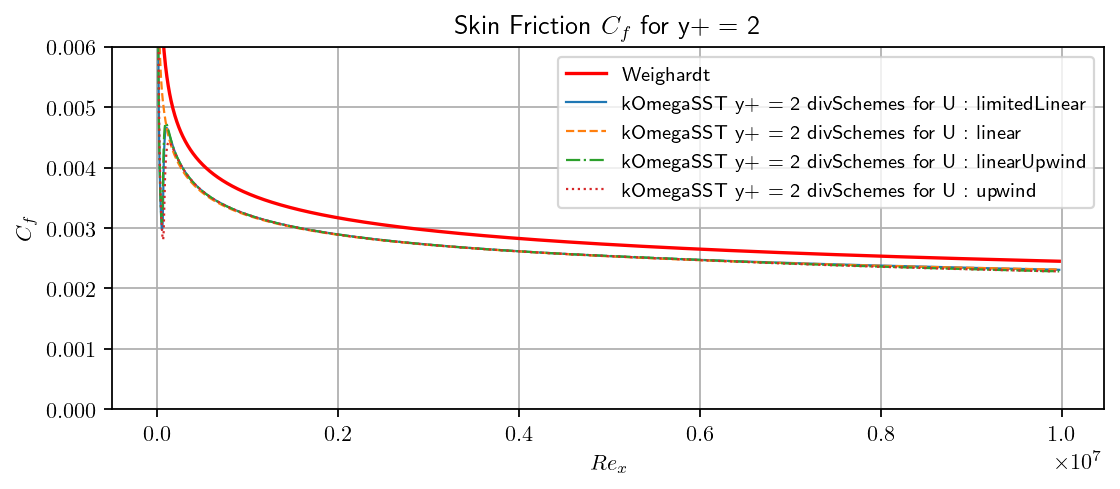

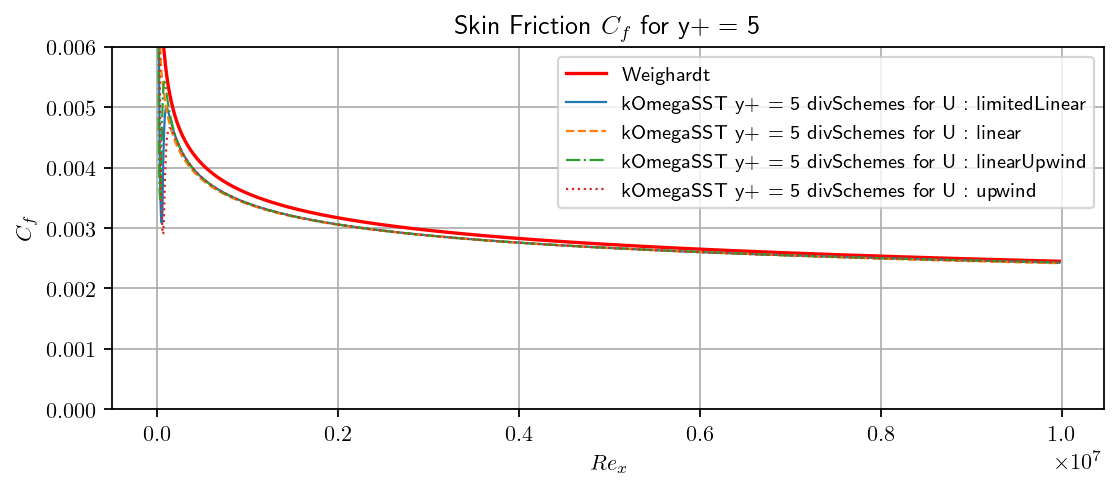

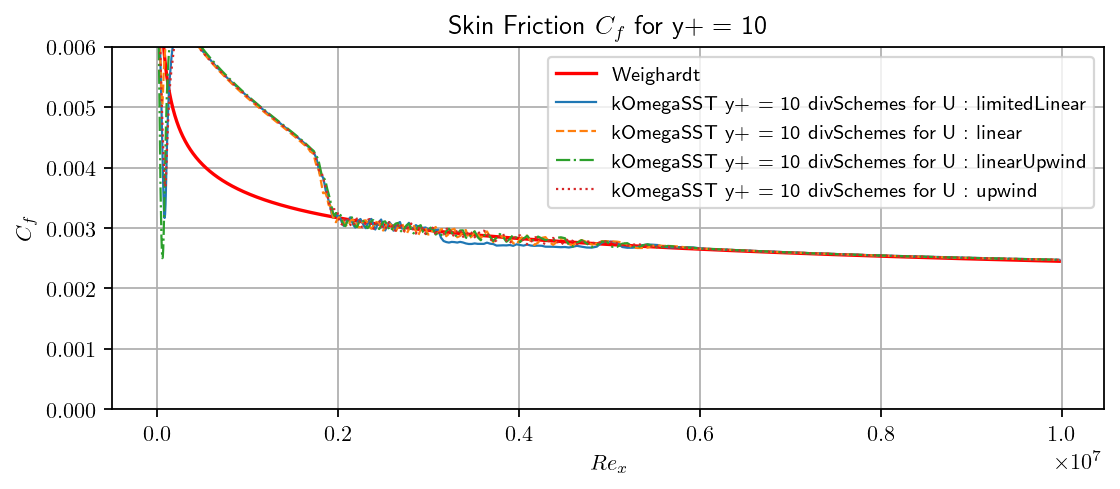

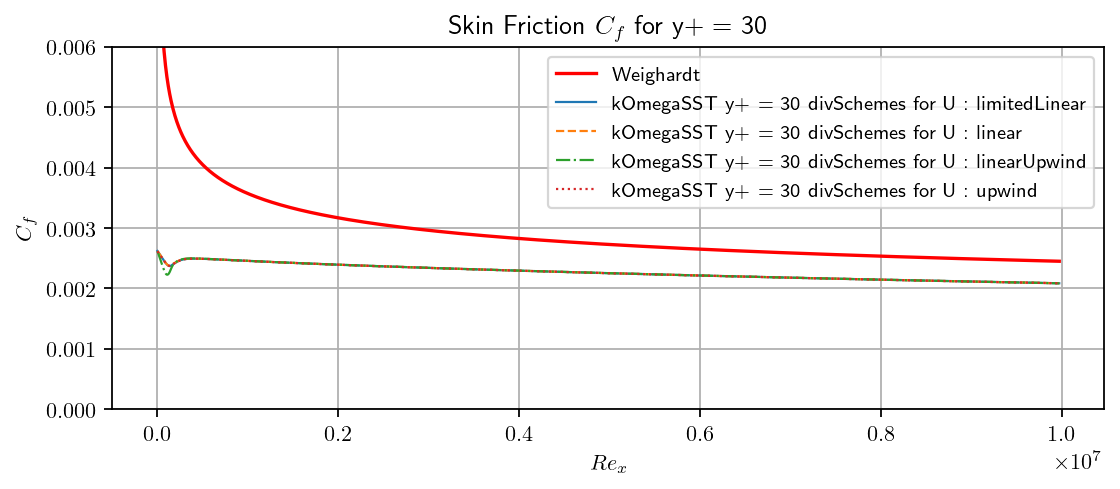

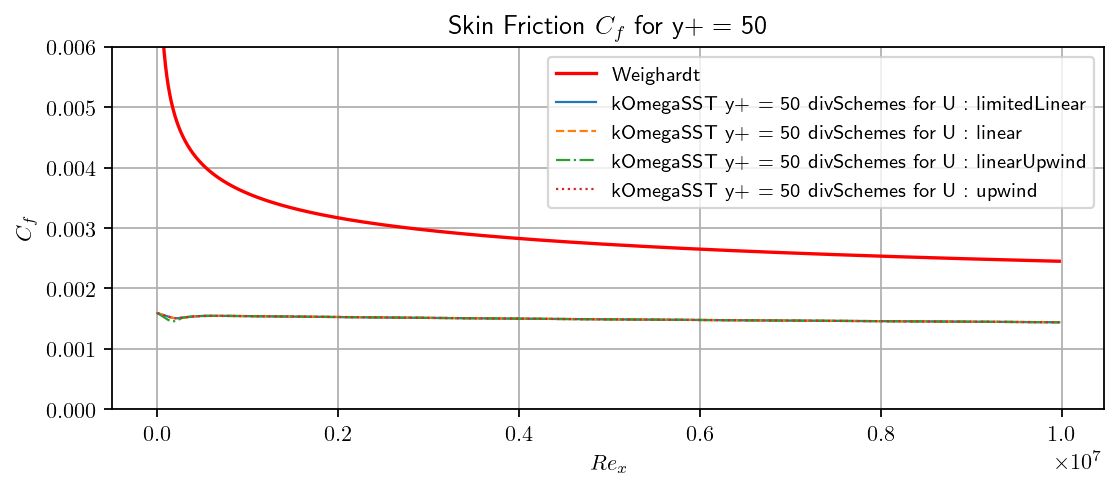

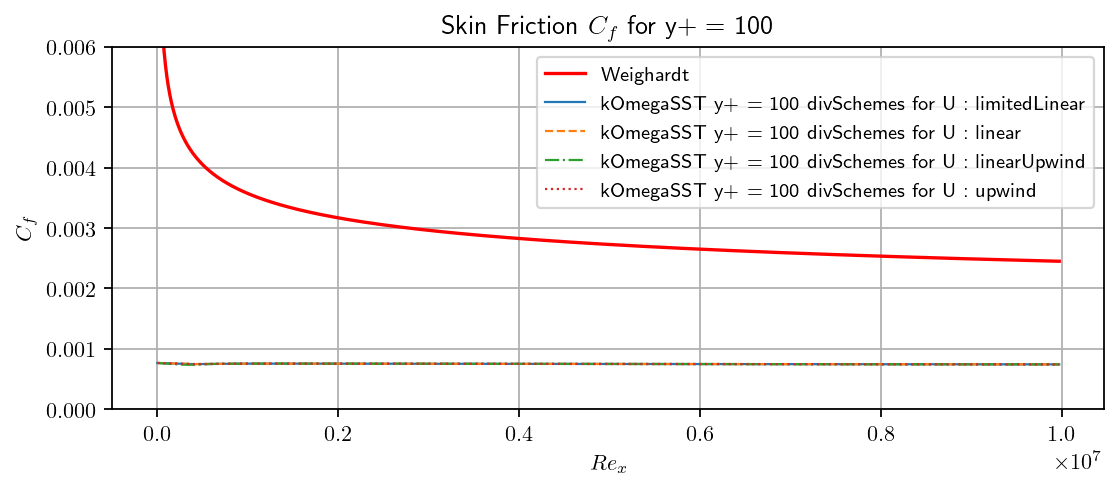

In [6]:
style = ["-", "--", "-.", ":"]
lw = 1.0
for j in range(len(yp)):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    plt.ylim([0, 0.006])
    plt.grid()
    ax.set_xlabel(r"$Re_x$")
    ax.set_ylabel(r"$C_f$")
    plt.title(r"Skin Friction $C_f$ for y+ = {}".format(yp[j]))
    ax.plot(Rex, weighardt, color = "r", label = "Weighardt")
    for i in range(len(divSchemes)):
        ax.plot(Rex, Cf[i + len(divSchemes)*j], label = "{} y+ = {} divSchemes for U : {}".format(model, yp[j], divSchemes[i]), ls = style[i], c = "C{:d}".format(i), lw = lw)
        ax.legend(fontsize = 9)
    plt.savefig(ds + "tauw_yp{}_{}_noWallFunc_divSchemes.pdf".format(yp[j], model), bbox_inches="tight")